In [1]:
import os 
import numpy as np 
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import gaussian_kde
import json

os.chdir('<project-dir>')

In [2]:
res = 5000
ref = 'mm10'
organism = 'Mus_Musculus'
loop_tool = 'fithichip'
loop_type = 'hichip-peaks'
loop_folder = 'fithichip_hp'

# output file
dist_fn = "results/loops/{loop_tool}/{sample_name}_{loop_type}.peaks/S5/"                                                                               
dist_fn += "FitHiChIP_Peak2ALL_b{res}_L20000_U2000000/P2PBckgr_1/Coverage_Bias/FitHiC_BiasCorr/"                                                  
dist_fn += "FitHiChIP-S5.interactions_FitHiC_Q0.01.loop_dist.txt"

## Load all distances

In [3]:
fns = glob.glob(dist_fn.format(sample_name='*', res=res, loop_tool=loop_tool, loop_type=loop_type))
fns = [x for x in fns if organism in x]

In [4]:
all_pulldowns = set(sorted([x.split('/')[3].split('.')[3] for x in fns]))

In [5]:
def parse_dist_file(fn):
    dists = []
    with open(fn) as fr:
        for line in fr:
            d = int(line.strip())
            dists.append(d)
    return dists
    
dists = {k:[] for k in all_pulldowns}
for fn in fns:
    pulldown = fn.split('/')[3].split('.')[3]
    cdists = parse_dist_file(fn)
    dists[pulldown].extend(cdists)

## Calculate density per lc pulldown group

In [6]:
lc_pulldown_groups = {'h3k27ac': ['H3K27ac'],
                   'ctcf': ['CTCF'],
                   'cohesin_complex': ['Rad21', 'SMC1A']}

In [7]:
lc_pulldown_values = {k:{} for k in lc_pulldown_groups.keys()}

In [8]:
threshold = 2000000
threshold = 1000000
kernel_dists = np.arange(0, 1000000, 5000)
for pulldown_grp, pulldown_list in lc_pulldown_groups.items():
    
    print(pulldown_grp)
    
    # extend data for given group
    grp_dists = []
    for pulldown in pulldown_list:
        if pulldown in dists:
            grp_dists.extend(dists[pulldown])
    
    # remove distances > threshold
    grp_dists = [x for x in grp_dists if x < threshold]
    
    if len(grp_dists) == 0:
        continue
    
    # calculate the density
    dists_arr = np.array(grp_dists).reshape(-1, 1)
    
    # train the kernel using all the data
    # tutorial at: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html
    kernel = gaussian_kde(dists_arr.reshape(-1))

    # get values from the kernel using uniq distances
    print('# get values from the kernel using uniq distances')
    dens = kernel(kernel_dists)

    # saving the values
    lc_pulldown_values[pulldown_grp]['dists_arr'] = dists_arr
    lc_pulldown_values[pulldown_grp]['kernel'] = kernel
    lc_pulldown_values[pulldown_grp]['dens'] = dens
    

h3k27ac
# get values from the kernel using uniq distances
ctcf
# get values from the kernel using uniq distances
cohesin_complex
# get values from the kernel using uniq distances


/tmp/ipykernel_74488/3579827664.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', '0kb', '200kb', '400kb', '600kb', '800kb', '1mb'])


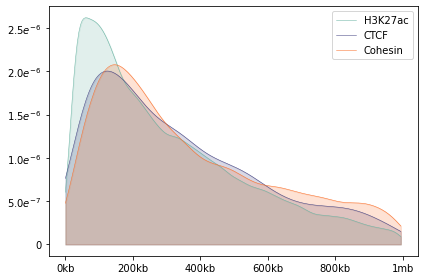

In [9]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots()
fig.subplots_adjust(left=0.05, right=0.95, hspace=0.05, wspace=0.05)

# setting colors
h3k27ac_color = "#69b3a2"
ctcf_color = "#404080"
cohesin_color = "#fa6e28"
colors = {'h3k27ac': h3k27ac_color, 'ctcf': ctcf_color, 'cohesin_complex': cohesin_color}
          
# setting plot names
legend_names = {'h3k27ac': 'H3K27ac', 'ctcf': 'CTCF', 'cohesin_complex': 'Cohesin'}

######################
# Adding density plots
######################
handles, labels = [], []
for i, pulldown_grp in enumerate(lc_pulldown_groups.keys()):
    
    if 'dens' in lc_pulldown_values[pulldown_grp]:

        x = kernel_dists
        y = lc_pulldown_values[pulldown_grp]['dens']

        handle, = ax.plot(x, y, color=colors[pulldown_grp], linewidth=0.5)
        ax.fill_between(x, y, color=colors[pulldown_grp], alpha=0.2)
        #ax.set_xlim(0, 2000000)
        handles.append(handle)
        labels.append(legend_names[pulldown_grp])

# Adding a legend
ax.legend(handles, labels)
    
######################
# Adjusting tick labels
######################

ax.set_xticklabels(['', '0kb', '200kb', '400kb', '600kb', '800kb', '1mb'])

# Define a custom function for formatting y-axis tick labels as power notation
def format_tick_power(x, pos):
    if x == 0:
        return "0"
    exponent = int(np.floor(np.log10(np.abs(x))))
    coeff = x / 10**exponent
    return f"${coeff:.1f}e^{{{exponent}}}$"

# Apply the custom tick formatter to the y-axis
ax.yaxis.set_major_formatter(plt.FuncFormatter(format_tick_power))

######################
# Save 
######################
outfn = 'results/loops/{loop_tool}/aggregations/{loop_folder}/density_plot.{ref}.{pulldown_grp}.{res}.loop_dist.png'
outfn = outfn.format(loop_tool=loop_tool, loop_type=loop_type, loop_folder=loop_folder,
             ref=ref, res=res, pulldown_grp=pulldown_grp)
fig.tight_layout()
fig.savefig(outfn, dpi=600)

## Save the dists

In [10]:
def make_hardlink(source, target):
    if os.path.exists(outlink):
        os.unlink(outlink)
    os.link(outfn, outlink)

In [11]:
for i, pulldown_grp in enumerate(lc_pulldown_groups.keys()):

    if 'dens' in lc_pulldown_values[pulldown_grp]:

        dens = lc_pulldown_values[pulldown_grp]['dens']

        kernel_coords = list(zip(kernel_dists, dens))
        kernel_coords = [list([float(x[0]), float(x[1])]) for x in kernel_coords]

        # save as json
        outfn = 'results/loops/{loop_tool}/aggregations/{loop_folder}/concatenation.{loop_tool}.{loop_type}.{ref}.{pulldown_grp}.{res}.loop_dist.json'
        outfn = outfn.format(loop_tool=loop_tool, loop_type=loop_type, loop_folder=loop_folder, ref=ref, res=res, pulldown_grp=pulldown_grp)
        with open(outfn, 'w') as fw:
            fw.write(json.dumps(kernel_coords))

        # add hardlink to json to transfer to lc storage
        outlink = 'results/loops/{loop_tool}/aggregations/{loop_folder}/loop_dist.{ref}.{pulldown_grp}.{res}.json'
        outlink = outlink.format(loop_tool=loop_tool, loop_type=loop_type, loop_folder=loop_folder, ref=ref, res=res, pulldown_grp=pulldown_grp)
        make_hardlink(outfn, outlink)

        # save as txt 
        outfn = 'results/loops/{loop_tool}/aggregations/{loop_folder}/concatenation.{loop_tool}.{loop_type}.{ref}.{pulldown_grp}.{res}.loop_dist.txt'
        outfn = outfn.format(loop_tool=loop_tool, loop_type=loop_type, loop_folder=loop_folder, ref=ref, res=res, pulldown_grp=pulldown_grp)
        with open(outfn, 'w') as fw:
            for x, y in kernel_coords:
                fw.write('{}\t{}'.format(x,y))



In [12]:
len(fns)

194